In [1]:
home_path = "/projects/ghnguyen_proj/project/git/SBA/4pm/"

In [10]:
COLOR_A = (118, 186, 153)
COLOR_B = (173, 207, 159)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
YELLOW = (255, 255, 0)
ORANGE = (226, 143, 65)
RED = (255, 0, 0)
MAGETA = (255, 0, 128)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

In [38]:
class bboxXYXY:      
    def __init__(self,x1 = None,y1 = None, x2 = None, y2 = None, shape = None, pad = 0):
        im_h, im_w = shape[0:2]
        padX, padY = int((x2-x1)*pad), int((y2-y1)*pad) 
        if y1 >= padY: y1 = y1 - padY
        if y1 < padY: y1 = 0
        if y2 + padY <= im_h: y2 = y2 + padY
        if y2 + padY > im_h: y2 = im_h
        if x1 >= padX: x1 = x1 - padX
        if x1 < padX: x1 = 0
        if x2 + padX <= im_w: x2 = x2 + padX
        if x2 + padX > im_w: x2 = im_w
            
        self.p1 = (int(x1), int(y1))
        self.p2 = (int(x2), int(y2))
        self.center = (int(x1+(x2-x1)/2), int(y1+(y2-y1)/2))
        
def imageWithMasks(im1, im2, im3, COLOR_A, COLOR_B):
    alpha = 0.3
    im1rgb = cv2.cvtColor(im1, cv2.COLOR_GRAY2RGB)
    #im1rgb = np.uint8(im1)
    im2 = cv2.threshold(im2, 128, 255, cv2.THRESH_BINARY)[1]
    im2rgb = cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)
    im2rgb = np.where(im2rgb==BLACK, im2rgb, COLOR_A)
    im2rgb = np.uint8(im2rgb)
    im3 = cv2.threshold(im3, 128, 255, cv2.THRESH_BINARY)[1]
    im3rgb = cv2.cvtColor(im3, cv2.COLOR_GRAY2RGB)
    im3rgb = np.where(im3rgb==BLACK, im3rgb, COLOR_B)
    im3rgb = np.uint8(im3rgb)
    im4rgb = im1rgb.copy()
    im4rgb = cv2.addWeighted(im2rgb + im3rgb, alpha, im4rgb, 1 - alpha, 0, im4rgb)
    im5 = cv2.threshold(im2 + im3, 128, 255, cv2.THRESH_BINARY)[1]
    im5rgb = cv2.cvtColor(im5, cv2.COLOR_GRAY2RGB)                 
    res1 = np.where(im5rgb!=BLACK, im4rgb, BLACK)
    res2 = np.where(im5rgb==BLACK, im1rgb, BLACK)
    res3 = cv2.bitwise_or(res1,res2)
    return res3

In [39]:
import cv2
import numpy as np
from utils import sba6pm, smartdisplay

Vertex at border
2  |  1  x  2


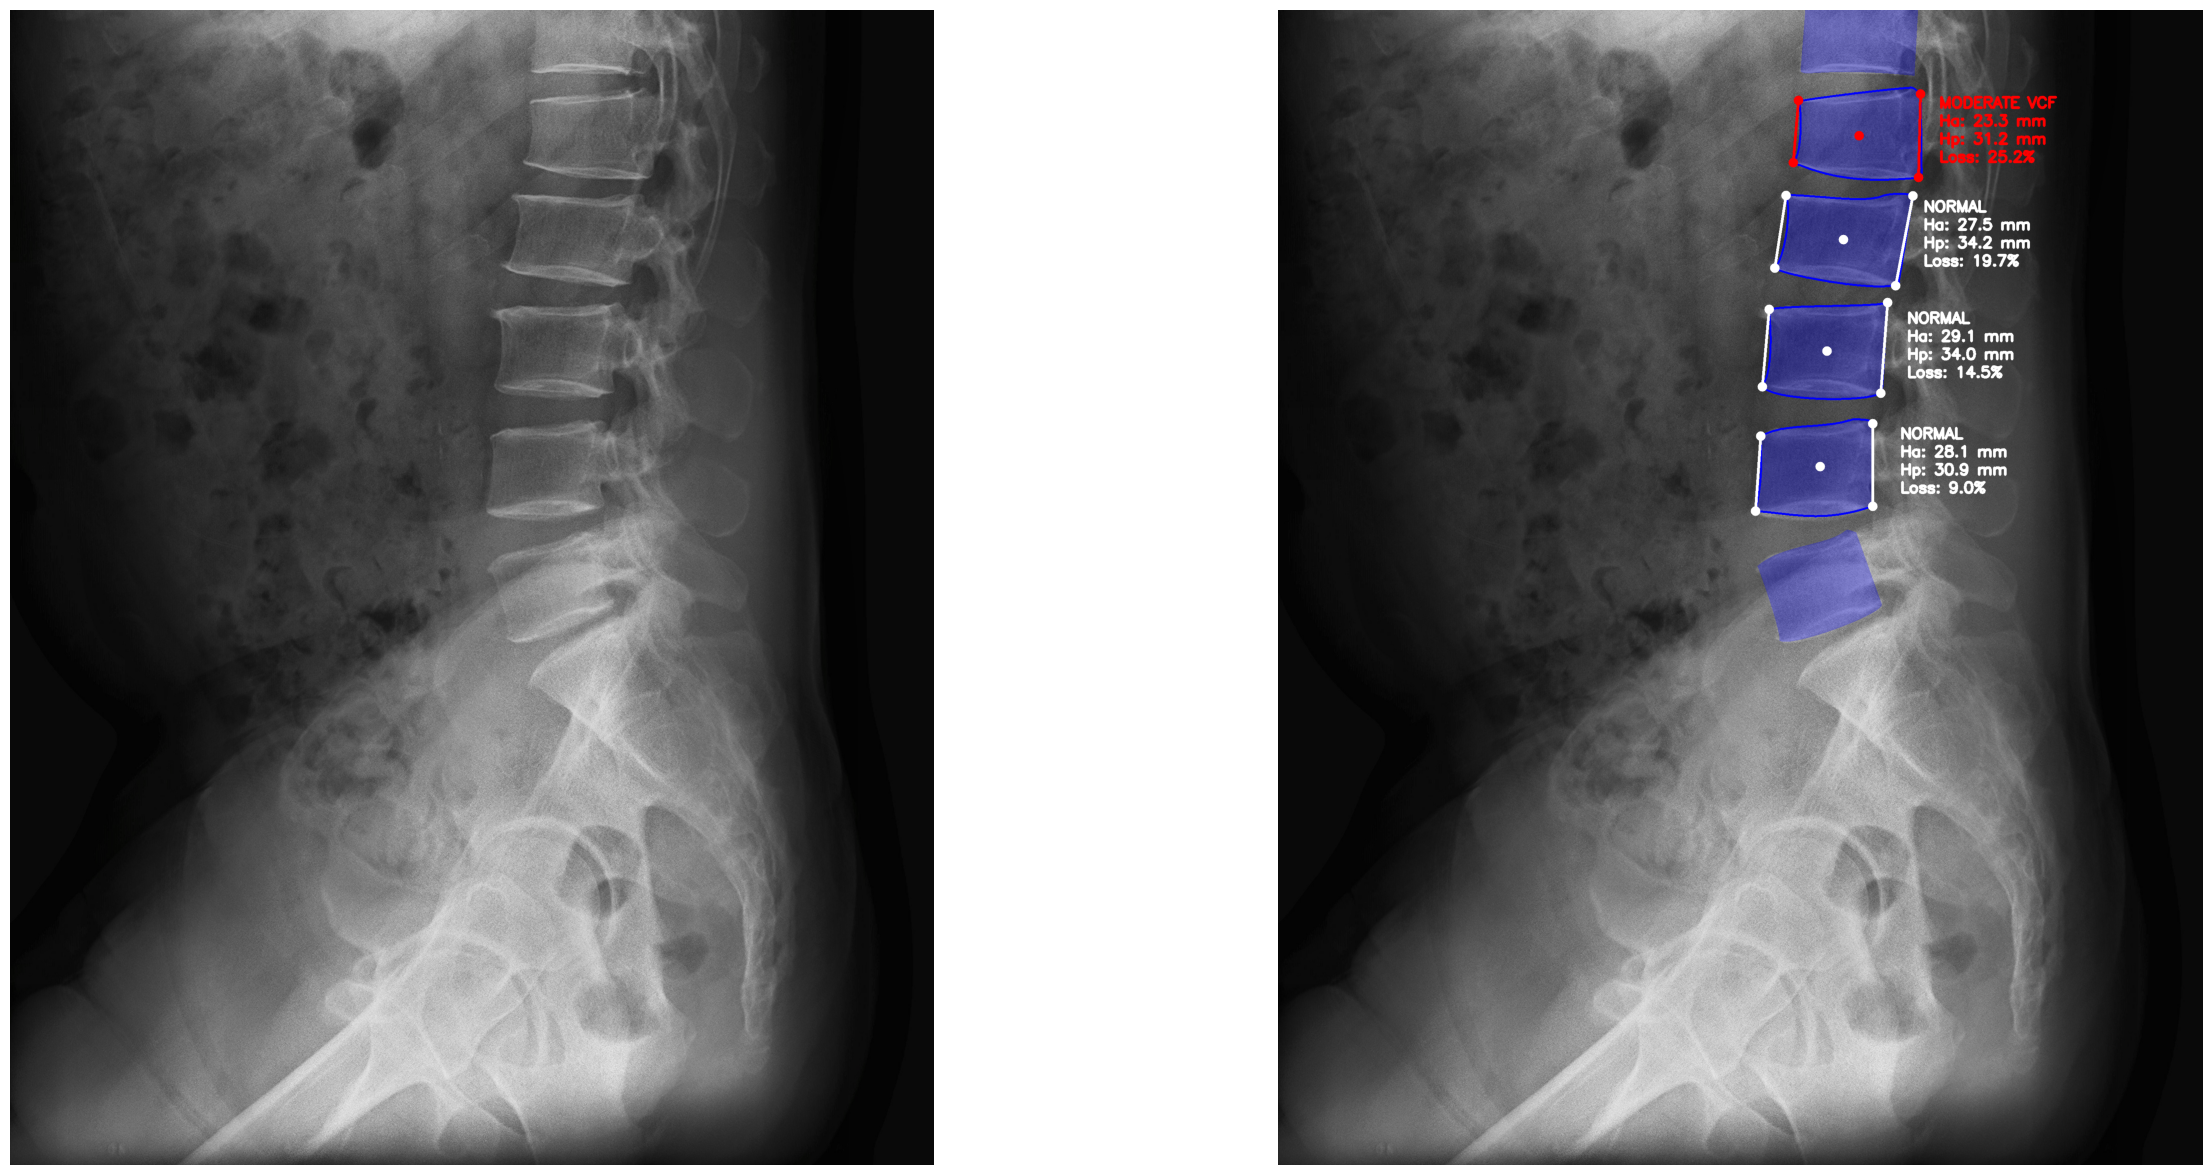

In [146]:
image = cv2.imread(home_path + "documents/1NBUUB/IMG.jpg", cv2.IMREAD_GRAYSCALE)
image_rgb = cv2.imread(home_path + "documents/1NBUUB/IMG.jpg", cv2.IMREAD_COLOR)
maskA = cv2.imread(home_path + "documents/1NBUUB/MSKA.jpg", cv2.IMREAD_GRAYSCALE)
maskB = cv2.imread(home_path + "documents/1NBUUB/MSKB.jpg", cv2.IMREAD_GRAYSCALE)
mask = cv2.bitwise_or(maskA,maskB)

height, width = image.shape[0:2]
lines = open(home_path + "documents/1NBUUB/1NBUUB.txt", 'r').readlines()
bboxes = []
for line in lines:
    line = line.rstrip('\n').split(" ")
    line = [float(i) for i in line]
    line[0] = str(int(line[0]))
    label  = str(int(line[0]))
    if label == '0':
        x1 = int((line[1] - (line[3] / 2)) * width)
        y1 = int((line[2] - (line[4] / 2)) * height)
        x2 = int((line[1] + (line[3] / 2)) * width)
        y2 = int((line[2] + (line[4] / 2)) * height)
        bboxes.append(bboxXYXY(x1, y1, x2, y2, image.shape, 0.15))
sorted_bboxes = sorted(bboxes, key=lambda x: x.center[1], reverse=True)

SPINE = []
for count, bbox in enumerate(sorted_bboxes):
    x1 = int(bbox.p1[0])
    y1 = int(bbox.p1[1])
    x2 = int(bbox.p2[0])
    y2 = int(bbox.p2[1])
    box_height = y2 - y1
    box_width = x2 - x1
    if count == 0:
        previous_box_height = box_height
    crop = image[y1:y2, x1:x2]
    crop_mask = mask[y1:y2, x1:x2]
    VERTEBRA = sba6pm.SBA(crop_mask)
    SPINE.append(VERTEBRA)

result = imageWithMasks(image,mask,mask,BLUE,BLACK)
NORMAL = WHITE
MILD = RED
MODERATE = RED
SEVERE = RED
for COUNT, VERTEBRA in enumerate(SPINE):
    if VERTEBRA.valid == 1 and COUNT > 0:
        if VERTEBRA.l > 0.2 and VERTEBRA.l <= 0.25: COLOR_CODE = MILD; GS_CODE = "MILD VCF"
        elif VERTEBRA.l > 0.25 and VERTEBRA.l <= 0.45: COLOR_CODE = MODERATE; GS_CODE = "MODERATE VCF"
        elif VERTEBRA.l > 0.45: COLOR_CODE = SEVERE; GS_CODE = "SEVERE VCF"
        else: COLOR_CODE = NORMAL; GS_CODE = "NORMAL"

        move_x = 200
        anchor = sorted_bboxes[COUNT].p1
        position = anchor + VERTEBRA.centroid
        
        cv2.drawContours(result, anchor + VERTEBRA.contour, -1, BLUE, 3)

        cv2.line(result,  anchor + VERTEBRA.a1, anchor + VERTEBRA.a2, COLOR_CODE, 5)
        cv2.line(result, anchor + VERTEBRA.p1, anchor + VERTEBRA.p2, COLOR_CODE, 5)

        cv2.circle(result, (anchor + VERTEBRA.a1), 12, COLOR_CODE, -1)
        cv2.circle(result, (anchor + VERTEBRA.a2), 12, COLOR_CODE, -1)
        cv2.circle(result, (anchor + VERTEBRA.centroid), 12, COLOR_CODE, -1)
        cv2.circle(result, (anchor + VERTEBRA.p1), 12, COLOR_CODE, -1)
        cv2.circle(result, (anchor + VERTEBRA.p2), 12, COLOR_CODE, -1)

        cv2.putText(result, ("{}".format(GS_CODE)), (position[0]+move_x, position[1]-70), cv2.FONT_HERSHEY_SIMPLEX, 1.25, COLOR_CODE, 6)
        cv2.putText(result, ("Ha: {} mm".format(round(VERTEBRA.ha*0.15,1))), (position[0]+move_x, position[1]-25), cv2.FONT_HERSHEY_SIMPLEX, 1.25, COLOR_CODE, 6)
        cv2.putText(result, ("Hp: {} mm".format(round(VERTEBRA.hp*0.15,1))), (position[0]+move_x, position[1]+20), cv2.FONT_HERSHEY_SIMPLEX, 1.25, COLOR_CODE, 6)
        cv2.putText(result, ("Loss: {}%".format(round(VERTEBRA.l*100,1))), (position[0]+move_x, position[1]+65), cv2.FONT_HERSHEY_SIMPLEX, 1.25, COLOR_CODE, 6)

smartdisplay.display([image_rgb, result], figsize=(30,15))